# Карикатура на изображение

Для достижения эффекта мультипликационного фильтра нам нужен двусторонний фильтр и обнаружение краев. Двусторонний фильтр уменьшит цветовую палитру в изображении, имитирующем мультяшный рисунок. Затем мы можем применить обнаружение краев к полученному изображению, чтобы создать смелые силуэты.


При этом существует пять основных шагов, по достижении которых достигается порог

1. Примените **bilateral filter** (цветовой фильтр), чтобы уменьшить цветовую палитру изображения.
2. Преобразуйте исходное цветное изображение в **grayscale** (оттенки серого).
3. Примените **median blur** (медиальное размытие), чтобы уменьшить шум изображения.
4. Используйте **adaptive thresholding** (адаптивное пороговое значение) для обнаружения и выделения ребер в маске ребер.
5. Объедините цветное изображение из шага 1 с краевой маской из шага 4.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Определите функцию цветового пространства для чтения вашего изображения

Чтобы задать несколько цветовых пространств для вывода изображения, будет задана функция. Это позволяет печатать изображение непосредственно в виде изображения RBG, HSV или оттенков серого и может быть запущено непосредственно после импорта библиотек

In [2]:
# Путь к картинке
img_dir = 'p1.jpg'

def rgb_img(img_dir):
    # Считывает данные из файла изображения BGR в файл RGB
    img = cv2.imread(img_dir)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def hsv_img(img_dir):
    # Считывает данные из файла изображения RGB в массив HSV
    hsv = cv2.imread(img_dir)
    return cv2.cvtColor(hsv, cv2.COLOR_RGB2HSV)

def img_read(img_dir):
    # Считывает данные из файла изображения RGB в массив изображений в оттенках серого
    rgb = rgb_img(img_dir)
    hsv = hsv_img(img_dir)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    return rgb, hsv, gray

In [3]:
# Каждой переменной присваивается свое значение функции
josh_rgb, josh_hsv, josh_gray = img_read(img_dir)

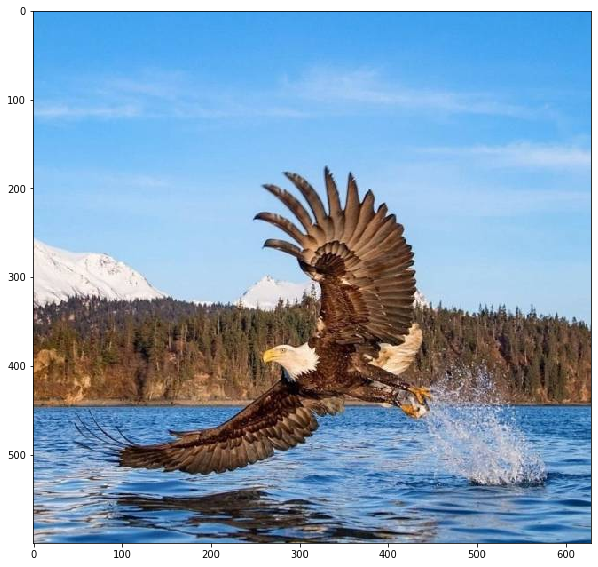

In [4]:
#  Создаем новую фигуру с задаными размерами (в дюймах)
plt.figure(figsize=(10,10))
# Отображаем изображение
plt.imshow(josh_rgb)

# Используем двусторонний фильтр для уменьшения цветовой палитры

Использование сильного двустороннего фильтра для изображения RGB подходит для преобразования изображения в мультфильм, потому что он сглаживает плоские области, сохраняя острые края.

Первый подход к снижению вычислительных затрат заключается в выполнении двусторонней фильтрации на изображении низкого разрешения. Для масштабирования изображения RGB (`imgRGB`) до четверти его размера мы используем `cv2.resize`:

In [5]:
# Уменьшение изображения в 4 раза
img_scale = cv2.resize(josh_rgb, (0,0), fx=0.5, fy=0.5)
# pyrDown - размывает изображение (по Гауссу) и уменьшает его качество
img_scale = cv2.pyrDown(josh_rgb)

Однако при таких масштабах двусторонний фильтр может по-прежнему работать слишком медленно, чтобы его можно было запускать в режиме реального времени. Другой вариант - многократно (скажем, пять раз) применять к изображению небольшой двусторонний фильтр:

Три аргумента в пользу `cv2.bilateralFilter`, он регулирует
- диаметр границ пикселей (`d`)
- стандартное отклонение фильтра в цветовом пространстве (`sigmaColor`)
- координатное пространство (`sigmaSpace`).

In [6]:
num_iter = 5
for _ in range(num_iter):
    img_scale = cv2.bilateralFilter(img_scale, d=9, sigmaColor=9, sigmaSpace=7)

In [7]:
# Восстановление изображения
josh_blur = cv2.pyrUp(img_scale)

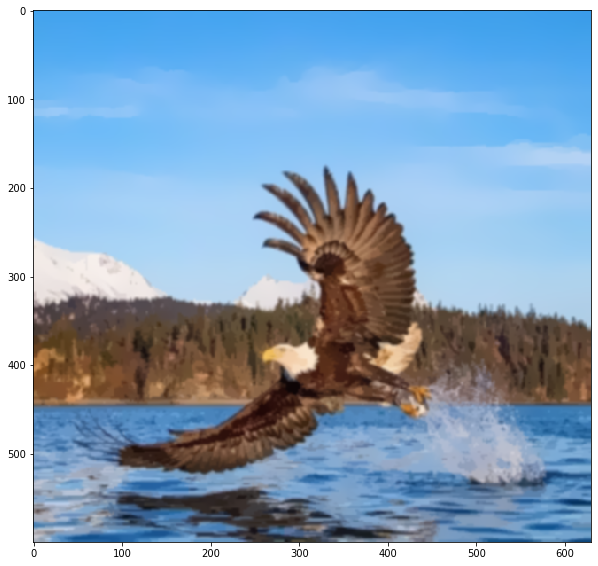

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(josh_blur)

# Обнаружение краев изображения.

Используя `cv2.adaptiveThreshold`, эта функция использует пороговое значение пикселя для преобразования изображения в оттенках серого в двоичное изображение. То есть, если значение пикселя в исходном изображении выше заданного порога, то значение пикселя в конечном изображении будет равно 255. В противном случае он будет равен 0. 

Сначала мы преобразуем изображение RGB (`josh_rgb`) в оттенки серого (`img_gray`) а затем примяем медианное размытие с локальной окрестностью, равной 7 пикселям (число должно быть нечетным):

In [9]:
# Преобразование в оттенки серого и применение медианного размытия
img_gray = cv2.cvtColor(josh_rgb, cv2.COLOR_RGB2GRAY)
img_blur = cv2.medianBlur(img_gray, 7)

После уменьшения шума мы можем обнаружить и усилить края, используя адаптивное пороговое значение. Алгоритм cv2.ADAPTIVE_THRESH_MEAN_C с размером блока=9 гарантирует, что порог будет применен к среднему значению окрестности 9 x 9 минус C=2:
*с окрестностью 3 х 3 минус C=2 смотрится тоже красиво

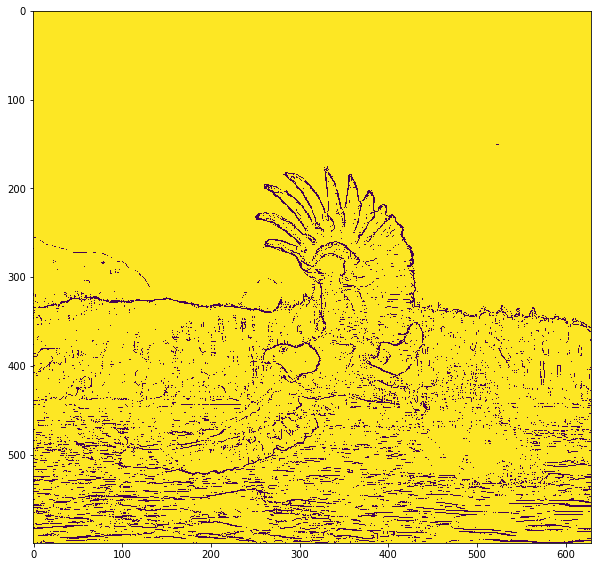

In [10]:
img_edge = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 3)
plt.figure(figsize=(10,10))
plt.imshow(img_edge)

# Комбинирование цветов и контуров для создания мультяшного эффекта

Последний шаг состоит в том, чтобы объединить два эффекта вместе в одно изображение с помощью `cv2.bitwise_and` для выполнения магии

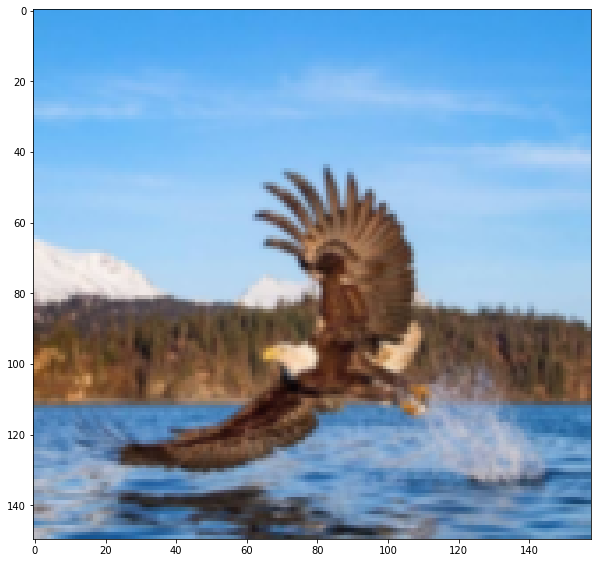

In [25]:
# Количество шагов снижения (экземпляров)
numDownSamples = 2 
# Количество шагов двусторонней фильтрации
numBilateralFilters = 7  

# Первый шаг
# Нисходящее изображение с использованием Гауссовой пирамиды 
img_color = josh_rgb
for _ in range(numDownSamples):
    img_color = cv2.pyrDown(img_color)

plt.figure(figsize=(10,10))
plt.imshow(img_color)  

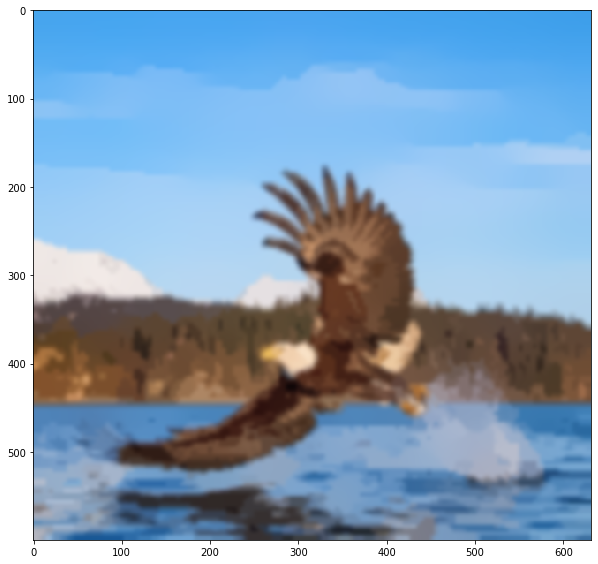

In [26]:
# Повторно применяем небольшой двусторонний фильтр вместо нанесения
    # Один большой фильтр
for _ in range(numBilateralFilters):
    img_color = cv2.bilateralFilter(img_color, 9, 9, 7)

    # Вверх по образцу изображения до исходного размера
for _ in range(numDownSamples):
    img_color = cv2.pyrUp(img_color)

plt.figure(figsize=(10,10))
plt.imshow(img_color)  

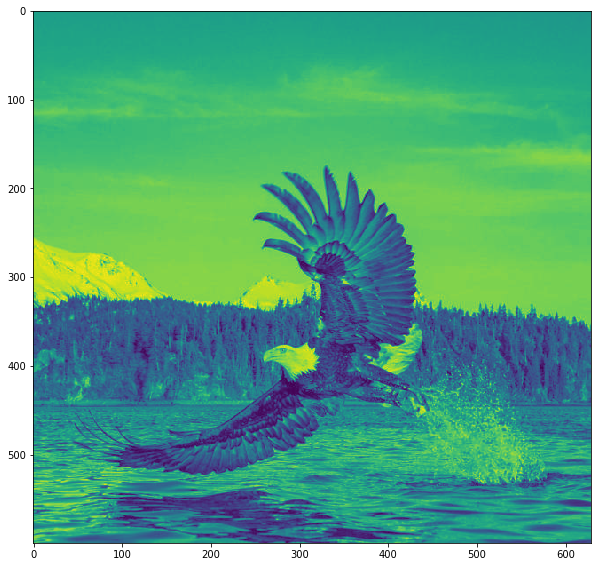

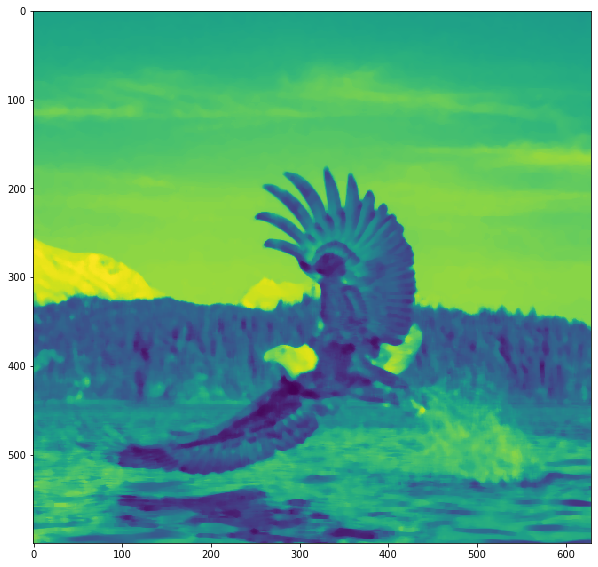

In [32]:
# Комбинируем шаги шаги 2 и 3
# Преобразование в оттенки серого и применение медианного размытия
img_gray = cv2.cvtColor(josh_rgb, cv2.COLOR_RGB2GRAY)
img_blur = cv2.medianBlur(img_gray, 7)

plt.figure(figsize=(10,10))
plt.imshow(img_gray)
plt.figure(figsize=(10,10))
plt.imshow(img_blur)  

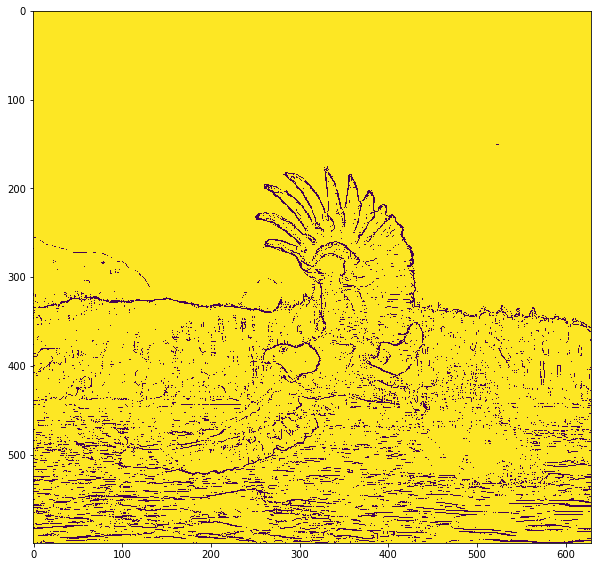

In [34]:
# Четвертый шаг
# Обнаружение и усиление краев
img_edge = cv2.adaptiveThreshold(img_blur, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 3)

plt.figure(figsize=(10,10))
plt.imshow(img_edge)  

In [35]:
# Пятый шаг
# Считывает данные из файла изображения GRAY в файл RGB
# with color image
img_edge = cv2.cvtColor(img_edge, cv2.COLOR_GRAY2RGB)
cv2.bitwise_and(img_color, img_edge)

error: OpenCV(4.4.0) /tmp/pip-req-build-njn2fp78/opencv/modules/core/src/arithm.cpp:232: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'


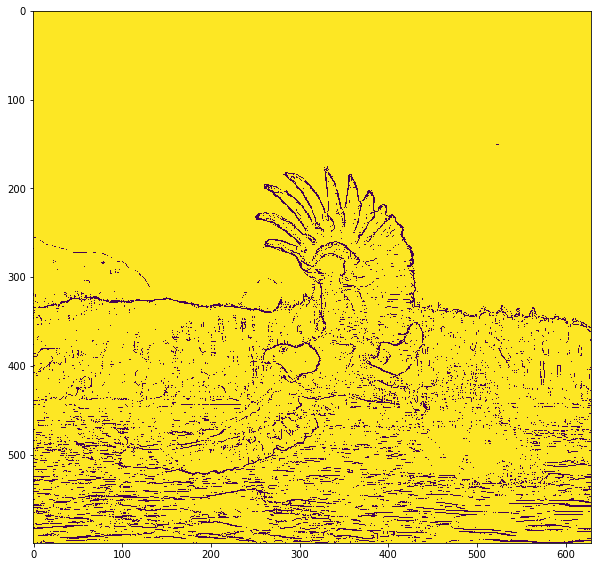

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(img_edge)

In [12]:
josh = cartoon_filter(img_edge, josh_rgb)
plt.figure(figsize=(10,10))
plt.imshow(josh)

error: OpenCV(4.4.0) /tmp/pip-req-build-njn2fp78/opencv/modules/core/src/arithm.cpp:232: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'
